# Transfer learning: build a cat vs dogs classifier

## Introduction
In this tutorial you will use Keras to build and fine-tune a cat and dog classifier using a model ([VGG16](https://arxiv.org/abs/1409.1556)) pre-trained on ImageNet and a very small data set of cat and dog images. The training set has only 200 images which is far too little to train a large CNN like VGG16 (ImageNet winner 2014). However, by freezing the weights in the pre-trained convolutional base of VGG16 and using it as a *feature extractor* we will only need to train the far smaller classification head.

### Keras
For this task we will use [Keras](https://keras.io/). Keras is an easy-to-use front end for [TensorFlow 2](https://www.tensorflow.org/). Keras follows best practices for reducing cognitive load: it offers consistent and simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear and actionable error messages. It also has extensive documentation and developer guides.


## Required libraries
* Pillow, the Python Image Library, aka PIL
* Keras, a Python Deep Learning library

### Install in notebook

Both Keras and Pillow are already installed on Google Colab.

```Python
!pip install Pillow
!pip install keras
!pip install tensorflow
```


## Imports

In [6]:
# conda install Pillow
#conda install keras
# conda install tensorflow

In [7]:
# import tensorflow as tf

In [8]:
# For data and utility
import os, shutil, random
# For feature extractor
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import numpy as np
# To display images
from IPython.display import Image
import matplotlib.pyplot as plt
# from keras.preprocessing import image
from keras import utils
# For the classification head
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

## Data
Upload the file ```data.zip``` to the current working directory.

On Google Colab you can upload files by clicking on the folder icon in the upper left of the browser window, and once it is loaded, click on the file upload icon (right below Files). The upload takes are few minutes.

If that doesn't work then you can run this code instead (i.e. copy and paste the code below into a code cell and run):
```python
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
```

Unce uploaded you can check the content of your current working directory with 
```python
ls
```
This should list `data.zip`.

Unzip it with the following command:

In [9]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!unzip data.zip
# in google colab and jupyter notebook, if you want to run Linux commands, you want to use !command

In [12]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/cats/
  inflating: data/train/cats/cat.0.jpg  
  inflating: data/train/cats/cat.1.jpg  
  inflating: data/train/cats/cat.2.jpg  
  inflating: data/train/cats/cat.3.jpg  
  inflating: data/train/cats/cat.4.jpg  
  inflating: data/train/cats/cat.5.jpg  
  inflating: data/train/cats/cat.6.jpg  
  inflating: data/train/cats/cat.7.jpg  
  inflating: data/train/cats/cat.8.jpg  
  inflating: data/train/cats/cat.9.jpg  
  inflating: data/train/cats/cat.10.jpg  
  inflating: data/train/cats/cat.11.jpg  
  inflating: data/train/cats/cat.12.jpg  
  inflating: data/train/cats/cat.13.jpg  
  inflating: data/train/cats/cat.14.jpg  
  inflating: data/train/cats/cat.15.jpg  
  inflating: data/train/cats/cat.16.jpg  
  inflating: data/train/cats/cat.17.jpg  
  inflating: data/train/cats/cat.18.jpg  
  inflating: data/train/cats/cat.19.jpg  
  inflating: data/train/cats/cat.20.jpg  
  inflating: data/train/cats/cat.21

Now you should have have a folder called "data" with three subfolders "test", "train" and "validation". Each of these three directories does, in turn, contain two directories "cats" and "dogs" containing, cat and dog images, respectively. Use `ls` to verify this. E.g. `ls data`, `ls data/test`, ...

**Tutorial question 1:** How many images are there in the validation set?

### Paths

Set up the paths to the training, validation and test data.

In [18]:
# set up paths to data

# os.path - make it reusable, factor in different operating systems

base_dir = os.path.join('.', 'data')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# for visualisation
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(validation_dir, 'cats')
val_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# size of datasets
train_size = len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))
validation_size = len(os.listdir(val_cats_dir)) + len(os.listdir(val_dogs_dir))
test_size = len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir))

In [20]:
# Tutorial Q1:
# How many images are in the validation set? 100 
validation_path = "/Users/christine/VSCode/MMAI5500_remote/MMAI5500/lecture_notes/lecture_4/data/validation"

validation_sz = len(os.listdir(val_cats_dir) +os.listdir(val_dogs_dir))

validation_sz

100

Print `test_dogs_dir`.

In [14]:
test_dogs_dir

'./data/test/dogs'

**Tutorial question 2**: Why is `os.path.join(...)` used instead of simply typing out the path (e.g. `./data/test/dogs` if you're on Linux)?

### Inspect a few images

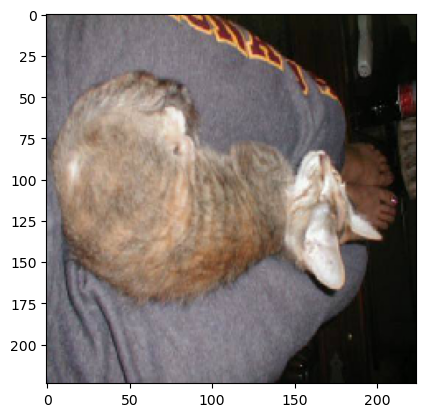

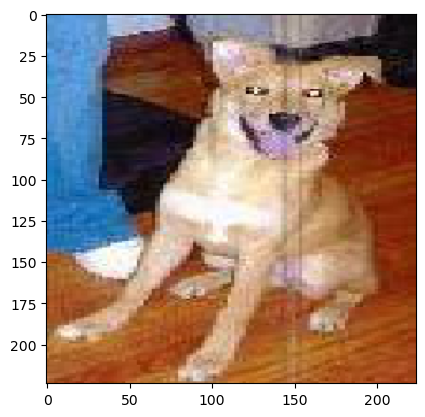

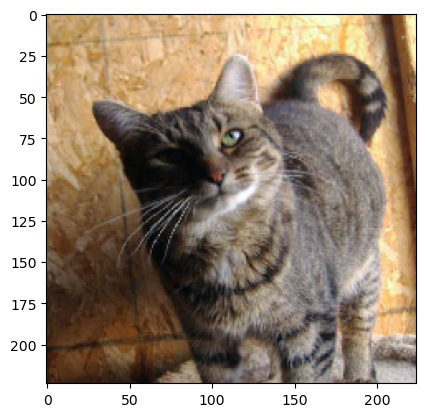

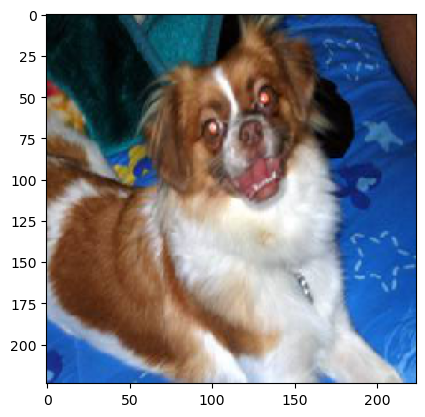

In [15]:
# Show pictures
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = utils.load_img(img_path, target_size=(224, 224))
    
    # We need to rescale due to different image sizes
    # Standardize = scale + normalize
    img_tensor = utils.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()

for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

## Feature extraction

### Prepare the feature extractor

Below we set up a method called `extract_features` to extract features from the training, validation and test sets. It takes two arguments, `directory` - the directory that the data is located in (e.g. `./data/train/`) and `sample_count` - the number of samples (images) to extract the features from. The method returns `features` - an array with `sample_count` rows and `7 * 7 * 512` (the number of features) columns.

To make life easier we use Keras utility class `ImageDataGenerator` to handle loading, batching and pre-processing of the data.

In the cell below, on the line where the convolutional base is loaded, you can see that the argument `include_top` is set to `False`. 

**Tutorial question 3:** What does the argument `include_top` control?

**Tutorial question 4:** Why is `include_top` set to `False`?

In [21]:
# Image size: height, width and number of channels in RGB (color) images.
im_w, im_h, im_ch = 224, 224, 3

# Load the convolutional base
conv_base = VGG16(weights='imagenet', # taken from here
                  include_top=False, # include classification head ("top"), do not include. Not fully sure why.
                  input_shape=(im_w, im_h, im_ch)) # pass the shapes


# Why do we not include "top"?
# It is poor at the task for the top (classification head)
# It makes sense to load and use this top once your model is trained up

# pre-processing
datagen = ImageDataGenerator(rescale=1./255) # divide by 255 rgb, values when loading between 0 to 255
# This is not a good range, to train faster, we normalize them to make it faster
# Must do the pre-processing steps as here for the datagen image
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(im_w, im_h),
                                            batch_size=batch_size, 
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
# Tutorial 5: normalize by 255
# Tutorial 6: 


# Depends on the preprocessing you do, you do different steps

In [ ]:
# Early Stoppage
# When 

**Tutorial question 5:** What pre-processing is done on the images in the cell above?

**Tutorial question 6:** Why is this pre-processing done?

**Tutorial question 7:** What will the value of `sample_count` be when features are extracted from the test data?

**Tutorial question 8:** In the cell above, the `batch_size` is set to `32`. Does this mean the weights are updated at intervals of 32 images (i.e. after every 32 images)?

### Extract the features

With `extract_features()` setup we can call it once for each of the data sets (train, validation and test).

In [22]:
# Extract features
train_features, train_labels = extract_features(train_dir, train_size)
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.


2024-10-02 17:03:04.266674: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 718ms/step
Found 100 images belonging to 2 classes.
1/1 [==============================] - 0s 354ms/step
Found 100 images belonging to 2 classes.
1/1 [==============================] - 0s 429ms/step


## The classification head

To set up the classification head (below called `model`) we will use Keras' [sequential API](https://keras.io/api/models/sequential/). The first layer (`layers.Flatten()`) is not a neural network layer in a normal sense (i.e. not a weight or neuron layer), but just an operation that flattens the 3-D feature array into a feature vector.

**Tutorial question 9:** What type of layer is created by `layers.Dense()` (i.e. a convolutional layer, fully connected layer, recurrent layer, locally connected layer, etc.)?

**Tutorial question 10:** How many weight layers are added to the classification head?

In [24]:
# Define the model
model = models.Sequential()
model.add(layers.Flatten(input_shape=(7, 7, 512))) # image 7 by 
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Shape - 7, 7, 512
# Fully connected to 256 neurons in next layer
# dropout - add one layer, with a dropout of 0.5


In [29]:
check = 7 * 7 * 512 * 256
check

# 6,423,041 parameters - trainable

6422528

### Train

Train the classification head using the method `model.fit()`.

In [35]:
# The number of epochs to train.
epochs = 100

#Add early stoppage for improvement:
callback = keras.callbacks.EarlyStopping(monitor = "loss", patience = 5)
# 

# Callbacks 
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks =[callback],
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 0s 23ms/step - loss: 7.9378e-04 - acc: 1.0000 - val_loss: 0.7384 - val_acc: 0.8200
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 8.0252e-04 - acc: 1.0000 - val_loss: 0.7211 - val_acc: 0.8400
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 6.8858e-04 - acc: 1.0000 - val_loss: 0.7027 - val_acc: 0.8400
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 6.1488e-04 - acc: 1.0000 - val_loss: 0.6858 - val_acc: 0.8500
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 7.7011e-04 - acc: 1.0000 - val_loss: 0.6860 - val_acc: 0.8500
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 5.1946e-04 - acc: 1.0000 - val_loss: 0.6880 - val_acc: 0.8500
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 4.1626e-04 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.8500
Epoch 8/100
7/7 [==============================] - 0s 19ms/ste

In [ ]:
# Patience and Callback for Keras
# Imagine your loss is like a big curve

# We will stop as soon as you find a local minima
# Patience = 5 epochs
# Will look 5 epochs further

**Tutorial question 11:** In the above cell, the validation data is given as input to `model.fit()`. Why?

### Inspect the training curves

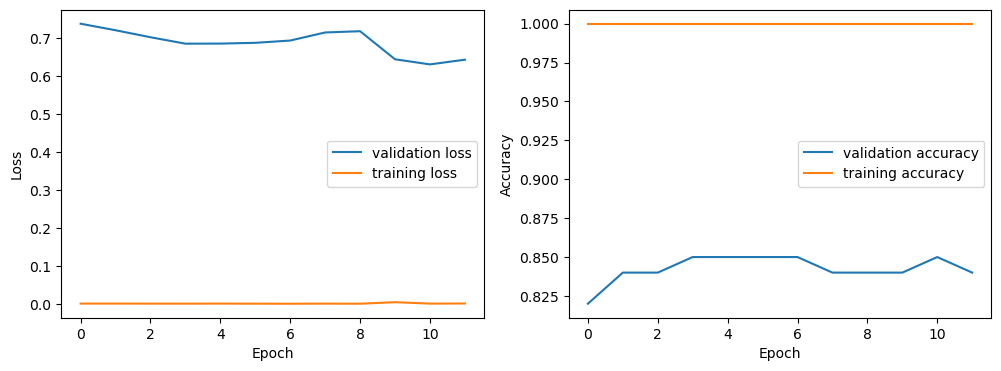

In [36]:
# Plot learning
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(121)
ax0.plot(history.history['val_loss'], label='validation loss')
ax0.plot(history.history['loss'], label='training loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend()
ax1 = fig.add_subplot(122)
ax1.plot(history.history['val_acc'], label='validation accuracy')
ax1.plot(history.history['acc'], label='training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

In [ ]:
# Noise for variance - distance between validation training
# 

# Zigzags + relatively close validation + training accuracy = we did not overfit

In [ ]:
# Yes we overfit
# Stop around epoch 20s, we see the vaidation accuracy curve flatten, which means we don't need to train further with epochs

**Tutorial question 12:** Did the model overfit?

**Tutorial question 13:** How can you tell whether the model overfit?

## Visualize predictions

Visualize a few (controlled by the argument `n_cases`) randomly selected images and their corresponding predictions.

In [33]:
# Function to visualize predictions
def visualize_predictions(classifier, n_cases):

  n_rows = int(np.ceil(n_cases / 3))

  fig = plt.figure(figsize=(4 * 3, 4 * n_rows))
    
  for i in range(n_cases):
      path = random.choice([test_cats_dir, test_dogs_dir])

      # Get picture
      random_img = random.choice(os.listdir(path))
      img_path = os.path.join(path, random_img)
      img = utils.load_img(img_path, target_size=(im_w, im_h))
      img_tensor = utils.img_to_array(img)  # Image data encoded as integers in the 0-255 range
      img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

      # Extract features
      features = conv_base.predict(img_tensor.reshape(1, im_w, im_h, 3))

      # predict
      prediction = classifier.predict(features)
        
      # Show picture
      ax = fig.add_subplot(n_rows, 3, i+1)
      ax.imshow(img_tensor)

      # Write prediction
      if prediction < 0.5:
          ax.set_title('Cat')
      else:
          ax.set_title('Dog')

  plt.show()

1/1 [==============================] - 0s 10ms/step


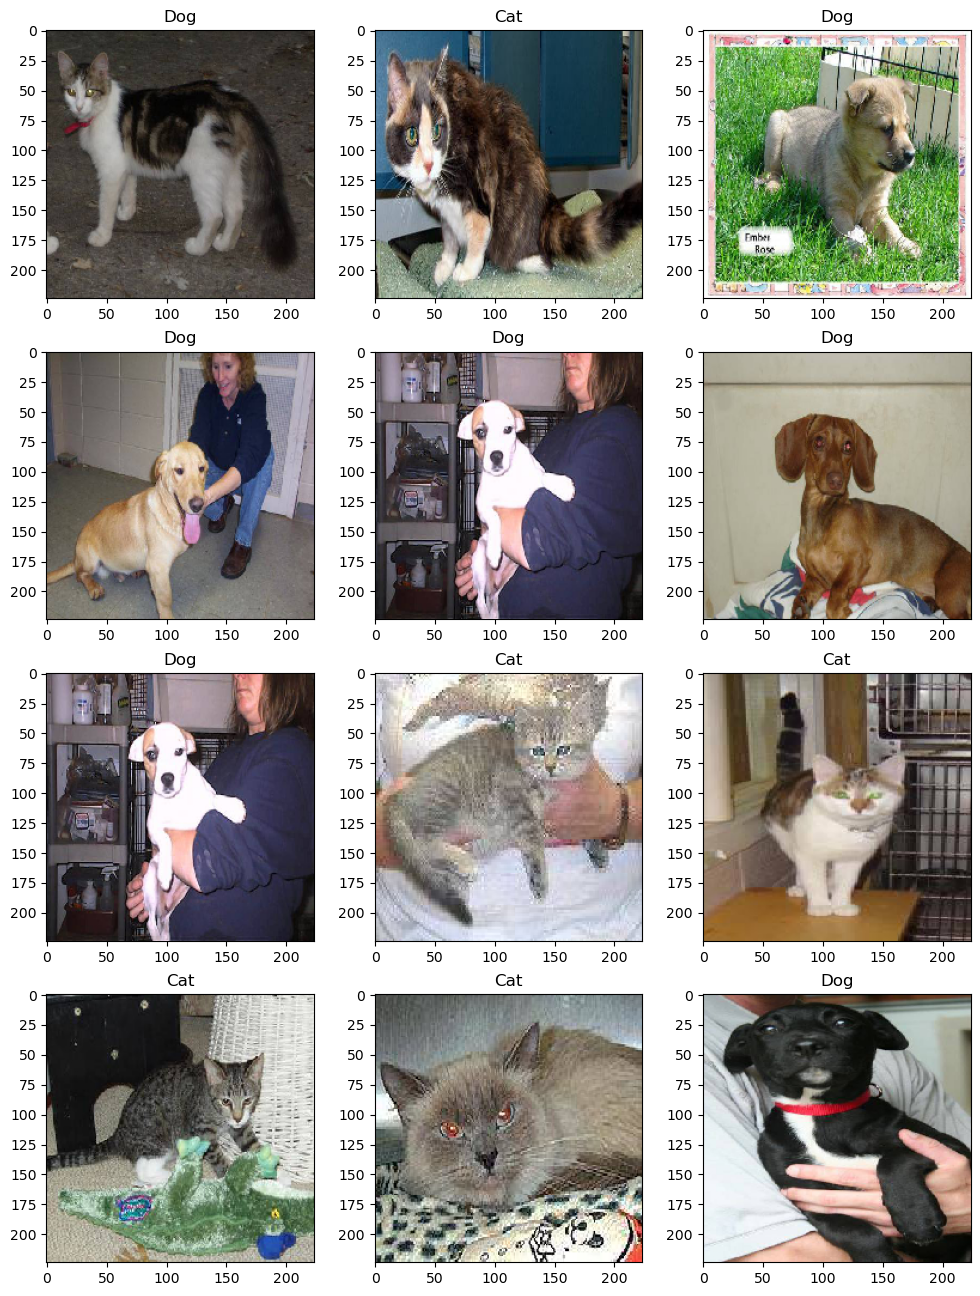

In [34]:
# Visualize predictions
visualize_predictions(model, 12)

**Tutorial question 14:** Were all the predicted labels correct?